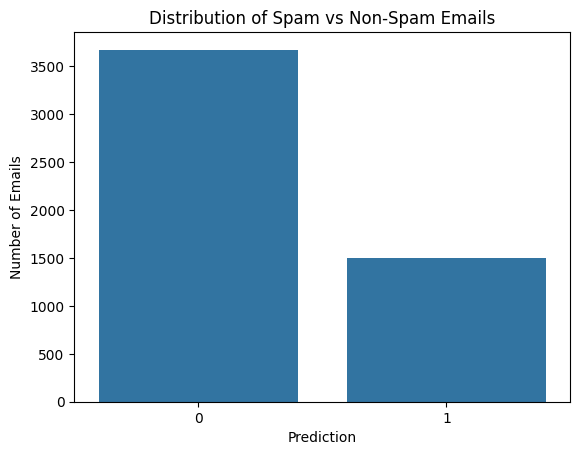

              precision    recall  f1-score   support

           0      0.988     0.967     0.977       736
           1      0.924     0.970     0.946       299

    accuracy                          0.968      1035
   macro avg      0.956     0.969     0.962      1035
weighted avg      0.969     0.968     0.968      1035
 [[712  24]
 [  9 290]]
              precision    recall  f1-score   support

           0      0.990     0.970     0.980       736
           1      0.930     0.977     0.953       299

    accuracy                          0.972      1035
   macro avg      0.960     0.973     0.966      1035
weighted avg      0.973     0.972     0.972      1035
 [[714  22]
 [  7 292]]


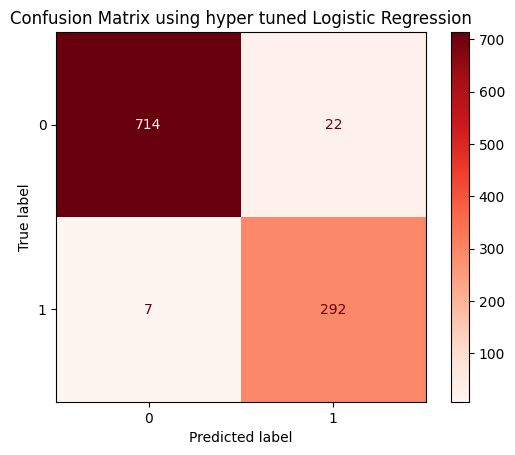

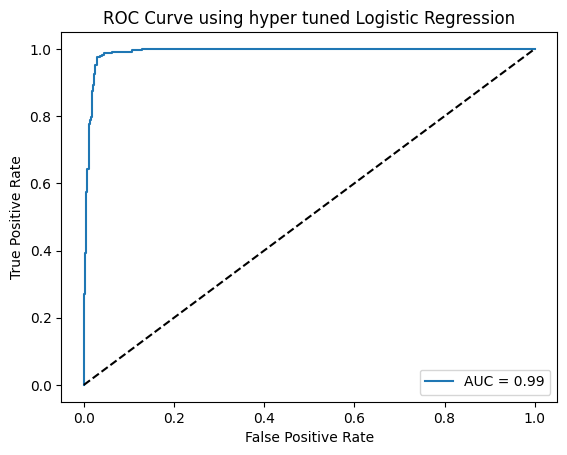

              precision    recall  f1-score   support

           0      0.868     0.821     0.844       736
           1      0.611     0.692     0.649       299

    accuracy                          0.784      1035
   macro avg      0.739     0.756     0.746      1035
weighted avg      0.794     0.784     0.787      1035
 0.185 0.101


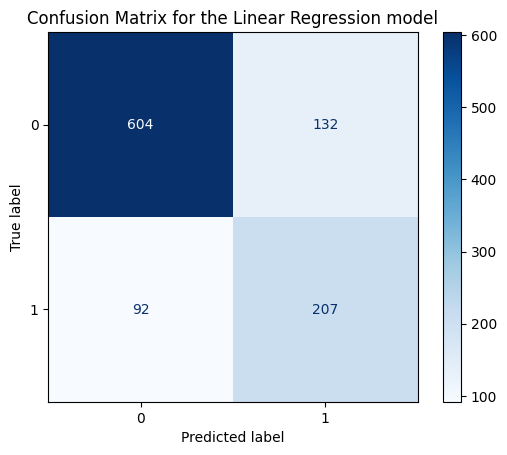

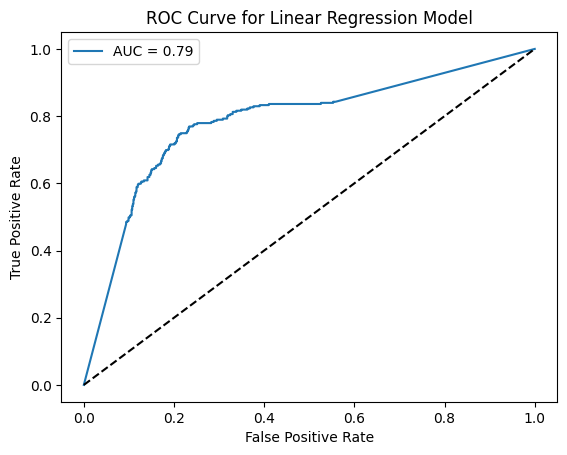

In [9]:
#link to code on Github:

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tr, GridSearchCV
from sklearn.linear_model import LogisticRegression as lr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("emails.csv")
df.head()
#plt.scatter(df["Email No."], df["Prediction"])

#viewing the number of normal vs spam emails in the prediction field
#sns.countplot(x=df["Prediction"], data=df)

#Setting up the x and the y variables

X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

#check the shape of the defined variables
#X.shape
#y.shape
#Plotting the distribution
sns.countplot(x=y)
plt.title("Distribution of Spam vs Non-Spam Emails")
plt.xlabel("Prediction")
plt.ylabel("Number of Emails")
plt.show()

#Scaling the dataset to normaliize the data ranges
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#setting up the training and testing data
X_train, X_test, y_train, y_test = tr(X_scaled, y, train_size=0.8, random_state=21)

#Basic logistic regression model
model = lr()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

cf = confusion_matrix(y_test, y_pred)
crp = classification_report(y_test, y_pred, digits=3)
print(crp, cf)

#Adding hyperparameter tuning
param_grid = { 
    "C": [0.01, 0.05, 0.1, 0.2, 0.5], 
    "penalty": ["l2"], 
    "solver": ["liblinear"],
    "class_weight": [None, "balanced", {0:1.2, 1:1}]  
}

# Use precision for non-spam (class 0) to reduce false positives
grid = GridSearchCV(
    lr(max_iter=1000), 
    param_grid, 
    cv=5, 
    scoring="accuracy",   
    n_jobs=-1
)

grid.fit(X_train, y_train)

#Replace the baisc model with the hyper tuned one
model = grid.best_estimator_
y_pred = model.predict(X_test)

#Print results
cf = confusion_matrix(y_test, y_pred)
crp = classification_report(y_test, y_pred, digits=3)
print(crp, cf)

#Display confusion matrix for tuned model
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix using hyper tuned Logistic Regression")
plt.show()

#Predicting the probabilities for the positive class
y_proba = model.predict_proba(X_test)[:,1]

#Computing the ROC curve for evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = round(auc(fpr, tpr),2)

#Plotting the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc}')
plt.plot([0,1],[0,1],'--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve using hyper tuned Logistic Regression')
plt.legend()
plt.show()

#Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#Predict on test set
y_pred_lr = linear_model.predict(X_test)

#Clip predictions to esnure they are within the range of 0 to 1 
y_pred_lr_clipped = np.clip(y_pred_lr, 0, 1)


#Convert predictions to 0/1 (threshold 0.5)
y_pred_class = (y_pred_lr_clipped >= 0.5).astype(int)

#Evaluation
cf_lr = confusion_matrix(y_test, y_pred_class)
crp_lr = classification_report(y_test, y_pred_class, digits=3)
mse = round(mean_squared_error(y_test, y_pred_lr_clipped), 3)
r2 = round(r2_score(y_test, y_pred_lr_clipped), 3)

print(crp_lr, mse, r2)

#Display confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cf_lr, display_labels=[0,1])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for the Linear Regression model")
plt.show()

#ROC curve for Linear Regression
y_proba_lr = y_pred_lr_clipped  
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr)
roc_auc_lr = round(auc(fpr_lr, tpr_lr), 2)

plt.plot(fpr_lr, tpr_lr, label=f'AUC = {roc_auc_lr}')
plt.plot([0,1],[0,1],'--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Regression Model')
plt.legend()
plt.show()
